## Pre-requisites

- Required Python packages:
    - Pandas for dataframes
    - Numpy for number calculations
    - Matplotlib & Seaborn for plotting
    - TQDM for tracking loop progress
    - Time for time tracking
- Import the environment functions defined in Part 1 from the env.py file

In [31]:
# Default Imports
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure

import tqdm
import time

import warnings
warnings.filterwarnings("ignore")

from IPython.display import clear_output

# Figure Formatting
sns.set(rc={'figure.figsize':(15, 10)})
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 5})
sns.set_style("whitegrid", {'axes.grid' : False})

# Import environment from env.py
from env import action_outcome
from env import environment
#------------------------------------------------------------------------------------------

#------------------------------------------------------------------------------------------
# ENVIRONMENT REQUIREMENTS
## Define states with 1) Labels, 2) Rewards and 3) [x,y] coordinates
#     | ----------- |
#   3 |  F  G  T  r |
# Y 2 |  E  #  M  t |
#   1 |  D  C  B  A |
#     | ----------- |
#      1  2  3  4
#          X

states = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', 'M', 'recycling', 'trash']
rewards = [-0.04, -0.04, -0.04, -0.04, -0.04, -0.04, -0.04, -0.04, -0.04, 1, -1]
x_list = [4,3,2,1,1,1,2,3,3,4,4]
y_list = [1,1,1,1,2,3,3,3,2,3,2]

## The low-level actions the agent can make in the environment
actions = ['left','right','up','down']
#------------------------------------------------------------------------------------------


# Part 2 - Online Model-Free Learning

## Q-Learning

Much like TD(0), Q-learning learns as we take each action but instead searches through the possible subsequent actions to learn faster. 



**Definition: Q-Learning Update Rule:** [Wiki](https://en.wikipedia.org/wiki/Q-learning)
\begin{equation}
 Q^{new}(s_{t},a_{t})\leftarrow (1-\alpha )\cdot \underbrace {Q(s_{t},a_{t})} _{\text{old value}}+\underbrace {\alpha } _{\text{learning rate}}\cdot \overbrace {{\bigg (}\underbrace {r_{t}} _{\text{reward}}+\underbrace {\gamma } _{\text{discount factor}}\cdot \underbrace {\max _{a}Q(s_{t+1},a)} _{\text{estimate of optimal future value}}{\bigg )}} ^{\text{learned value}}
 \end{equation}

where:

- $Q(s_t,a_t)$ is the value of state-action pair $s$, 
- $\alpha$ is the **learning rate parameter**, 
- $r$ is the reward,
- $\gamma$ is the **discount factor parameter** and, 
- $Q(s_{t+1}, a )$ is the value of action-pairs in the next state.

For now, we will fix the parameters to be $\epsilon = 0.1$,  $\alpha = 0.2 $ and $\gamma = 0.8$ but encourage you to try variations by editing these and re-running the cell. 


## Action Selection Method: $\epsilon$-Greedy


We could use a random selection process but this is a highly inefficient method of choosing which action to take. When we implement our learning process we will begin to learn which actions lead towards the positive goal so if we keep randomly selecting we are wasting all that effort.

Therefore, we instead introduce a method that takes this into account, known as **epsilon-greedy**.

*The best lever is selected for a proportion $1-\epsilon$ of the trials, and a lever is selected at random (with uniform probability) for a proportion $\epsilon$ . A typical parameter value might be $epsilon =0.1$, but this can vary widely depending on circumstances and predilections.* ([wiki](https://en.wikipedia.org/wiki/Multi-armed_bandit))

In other words, we pick an action randomly with probability $\epsilon$ and will otherwise pick the best action. If we have mutliple "best actions" we then randomly select from this list.

So why do we not simply keep picking the best action each time? Well this can cause a problem if we have an action that works but is not neccessarily the best. This is often considered in other Machine Learning problems as the local minimum/maxmum. If we keep using an action that seems to work we may miss the opportunity to try a better action because we never tried it and this can cause instability in the results. 

The animation below demonstrates the outcome as we reduce epsilon. With high epsilon values, we are randomly selecting actions so will likely pick bad ones. As we reduce epsilon we select actions more and more greedily improving the results whilst still ensuring we can explore new actions to minimise the risk we are in a local max ratherh than global max.

**We therefore select a small epislon value $\epsilon = 0.1$**

![epsilon varied](https://i.imgur.com/Rx7HVAE.gif)

There are other methods that can be considered, such as the [Softmax Function](https://en.wikipedia.org/wiki/Softmax_function).

#### Action Cap
We also introduce an **action cap** which stops the episode occuring endlessly. If we reach this cap then we can consider the episode goal as negative but set it very large so is unlikely to reach it.

## Environment Function Output

In [33]:
for i in range(0,5):
    print("-------------------------------------------------")
    print(" ")
    print(environment(states, actions, rewards, x_list, y_list, 'A', 'left'))
    print(" ")

-------------------------------------------------
 
('A', 'up', 4, 1, 0, 1, 'trash', 4, 2, -1)
 
-------------------------------------------------
 
('A', 'right', 4, 1, 0, 0, 'A', 4, 1, -0.04)
 
-------------------------------------------------
 
('A', 'left', 4, 1, -1, 0, 'B', 3, 1, -0.04)
 
-------------------------------------------------
 
('A', 'left', 4, 1, -1, 0, 'B', 3, 1, -0.04)
 
-------------------------------------------------
 
('A', 'left', 4, 1, -1, 0, 'B', 3, 1, -0.04)
 


## Applying Agent

In [36]:
#------------------------------------------------------------------------------------------
# Initialise RL agent

## Fix episode start if running on small scale for understanding
start_state = None

## Parameters
num_episodes = 1000
epsilon = 0.1
num_random_episodes = 50
alpha = 0.2
gamma = 0.8

## Initialise Q Values equal to 0
Q_table = pd.DataFrame()
for n1,state in enumerate(states):
    action_list = pd.DataFrame()
    for n2,action in enumerate(actions):
        state_x = x_list[n1]
        state_y = y_list[n1]
        u = action_outcome(state_x,state_y,action)[0]
        v = action_outcome(state_x,state_y,action)[1]
        action_list  = action_list.append(pd.DataFrame({'state':state,'x':x_list[n1],'y':y_list[n1],'u':u,'v':v, 'action':action}, index=[(n1*len(actions)) + n2]))

    Q_table = Q_table.append(action_list)
Q_table['Q']=0

Q_table.head()

,state,x,y,u,v,action,Q
0,A,4,1,-1,0,left,0
1,A,4,1,0,0,right,0
2,A,4,1,0,1,up,0
3,A,4,1,0,0,down,0
4,B,3,1,-1,0,left,0


In [37]:
Q_value_tracker = pd.DataFrame()
for episode in range(0,num_episodes):
    # Track episode number with simple print function
    clear_output(wait=True)
    print("Episodes Completed: ", np.round( (episode/num_episodes)*100,2),"%")
    
    # Add this so start state doesn't need to be given by user input
    if (start_state is None):
        state = random.choice(states)
    else:
        state = start_state
        
    # Initialise action loop    
    a = 1
    while True:
        # End loop at terminal states
        if (state == 'recycling')|(state == 'trash'):
            break
        else:
            # Apply epsilon-greedy
            #------
            # We set first few episodes to follow purely randomly selection for exploration
            greedy_rng = np.random.rand()
            if (episode<num_random_episodes):
                action = random.choice(actions)
            # Randomly select with P=epsilon
            elif (greedy_rng <= epsilon):
                action = random.choice(actions)
            # Greedy (max value currently) otherwise 
            else:
                # Pick action in state with highest Q value, randomly select if multiple match same max value
                Q_table_max = Q_table[Q_table['Q'] == max(Q_table['Q'])]
                if len(Q_table_max)>1:
                    action = Q_table_max.sample().iloc[0]['action']
                else:
                    action = Q_table_max.iloc[0]['action']
            #------
            # Environment probabilistric outcome
            #---
            # environment fn output: return(state, action, state_x, state_y, u, v, next_state, next_state_x, next_state_y, reward)
            outcome = environment(states, actions, rewards, x_list, y_list, state, action)
            
            new_state = outcome[6]
            #new_x = outcome[7]
            #new_y = outcome[8]
            r = outcome[9]
            #------
            
            
            # Update Values
            #------
            # Update Q based on episode outcome
            # Q learning update: Q(s_{t},a_{t}) <-- (1-alpha)*Q(s_{t},a_{t}) + alpha[r + gamma*max(Q(s_{t+1},a))]
            Q_table_new_state = Q_table[Q_table['state']==new_state]
            max_Q_new_state = Q_table_new_state[Q_table_new_state['Q'] == max(Q_table_new_state['Q'])].iloc[0]['Q']
            
            Q_table['Q'] = np.where( (Q_table['state']==state)&(Q_table['action']==action), 
                                    ((1-alpha)*Q_table['Q']) + (alpha*(r + (gamma*max_Q_new_state))),
                                    Q_table['Q'] )
            #------
            
            # Move to next action, make the new state the current state
            #------
            a=a+1
            state=new_state
            #------

    Q_value_tracker = Q_value_tracker.append(pd.DataFrame({'episode':episode, 'mean_Q': Q_table['Q'].mean(),'total_Q':Q_table['Q'].sum()}, index=[episode]))

Episodes Completed:  99.9 %


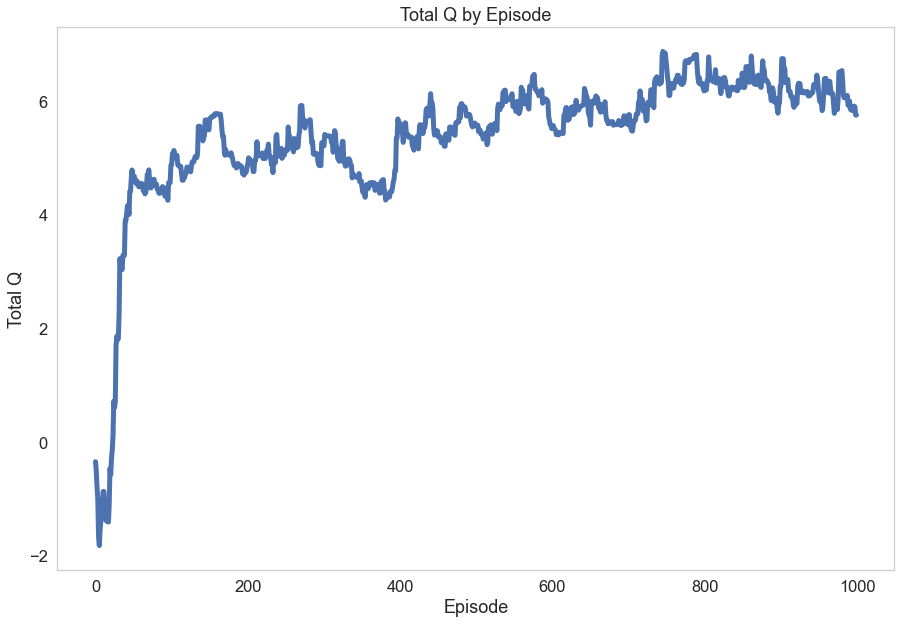

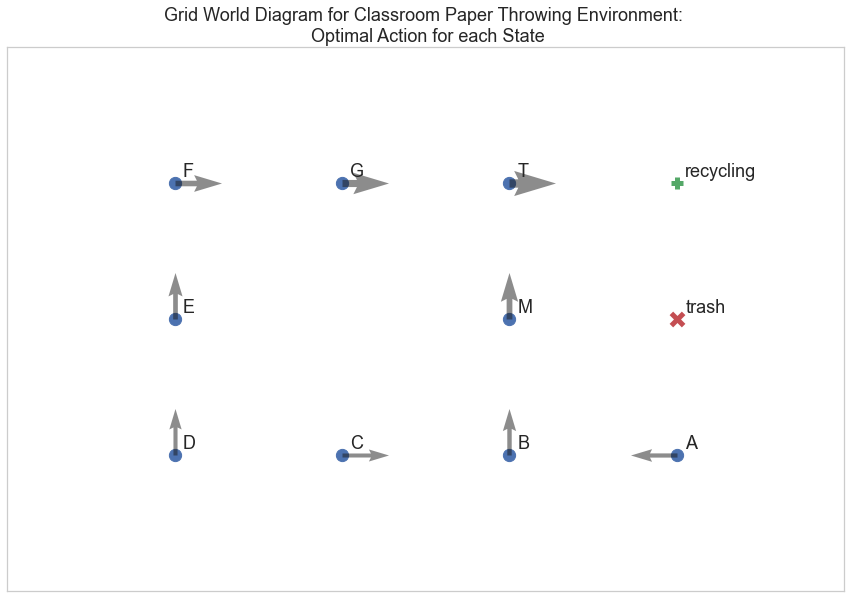

In [38]:
Q_table_output = Q_table
Q_table_tracker_output = Q_value_tracker

plt.plot(Q_table_tracker_output['total_Q'])
plt.ylabel("Total Q")
plt.xlabel("Episode")
plt.title("Total Q by Episode")
plt.show()

# Normalise so we can still plot negative values
Q_table_output['Q_norm'] = (Q_table_output['Q']-min(Q_table_output['Q']))/( max(Q_table_output['Q']) - min(Q_table_output['Q']) )
Q_table_output.head(50)

# Plot best actions in each state
for n,state in enumerate(states):
    if state == 'recycling':
        plt.scatter(x_list[n],y_list[n], s=150, color='g', marker='+')
    elif state == 'trash':
        plt.scatter(x_list[n],y_list[n], s=150, color='r', marker='x')
    else:
        plt.scatter(x_list[n],y_list[n], s=150, color='b')
    plt.text(x_list[n]+0.05,y_list[n]+0.05,states[n])
    Q_table_output_state = Q_table_output[Q_table_output['state']==state].reset_index(drop=True)
    for action in range(0,len(Q_table_output_state)):
        if (Q_table_output_state['Q_norm'].iloc[action] == Q_table_output_state['Q_norm'].max()):
            plt.quiver(x_list[n],y_list[n],Q_table_output_state['u'][action],Q_table_output_state['v'][action], alpha = 0.5,
                      width = 0.01*Q_table_output_state['Q_norm'][action])
    
plt.title("Grid World Diagram for Classroom Paper Throwing Environment: \n Optimal Action for each State")
plt.xticks([])
plt.yticks([])
plt.ylim(0,4)
plt.xlim(0,5)
plt.show()